## Run a single example of the calibration for a certain set of parameters

In [1]:
import PyPlot
const plt = PyPlot;

using PyCall
const matplotlib = pyimport("matplotlib")
rcParams = PyDict(matplotlib["rcParams"])
rcParams["font.family"] = "Times New Roman"
rcParams["font.size"] = 12;

In [5]:
include("ms_calibration.jl")

detuning_khz = 10
pi_time_blue_μs = 5
pi_time_red_μs = 7
sym_ac_stark_shift_khz = real_sym_ac_stark_shift_khz
#antisym_ac_stark_shift_khz = real_antisym_ac_stark_shift_khz
θ = HamiltonianParameters([
    detuning_khz,
    pi_time_blue_μs,
    pi_time_red_μs,
    sym_ac_stark_shift_khz,
    #antisym_ac_stark_shift_khz,
])

HamiltonianParameters(10.0, 5.0, 7.0, 1.0)

In [6]:
# demonstrate that we achieve >99.99% fidelity with ideal parameters
@time ms_fidelity(θ, θ)

 35.696009 seconds (83.76 M allocations: 4.285 GiB, 4.07% gc time)


0.999982567685952

In [7]:
include("ms_calibration.jl")

function rand_coeff()
    # returns a uniform random float in [0.9, 1.1]
    return 0.9 + (rand() * 0.2)
end

param_count = length(fieldnames(HamiltonianParameters))
initial_guess = HamiltonianParameters([as_vector(θ)[i] * rand_coeff() for i in 1:param_count])

N = 100
tspan_ideal = 0:0.1:200
tspan_experiment = 0:20:180

@time res = ms_calibration(θ, initial_guess, N, tspan_ideal, tspan_experiment)

ideal_fit_params = as_vector(res["ideal_fit_params"])
learned_fit_params = as_vector(res["learned_fit_params"])
error = [ideal_fit_params[i] - learned_fit_params[i] for i in 1:param_count]
relative_error = [error[i] / ideal_fit_params[i] for i in 1:param_count]

  6.315707 seconds (38.76 M allocations: 1.762 GiB, 5.14% gc time)


4-element Array{Float64,1}:
 -0.003027256950025681
  0.0281820342308853
 -0.029197115156714176
  0.3493833887907809

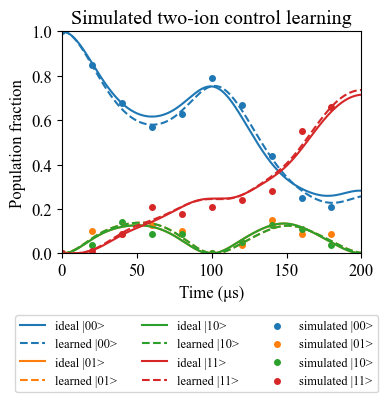

total shots=1000
ideal fit parameters [10.0, 5.0, 7.0, 1.0]
learned fit parameters [10.030272569500257, 4.8590898288455735, 7.204379806096999, 0.6506166112092191]
fit parameters relative error=[-0.003027256950025681, 0.0281820342308853, -0.029197115156714176, 0.3493833887907809]


In [8]:
ideal = res["ideal_curve"]
learned = res["learned_curve"]
experimental = res["experimental_data"]

state_labels = Dict(
    "SS" => "|00>",
    "SD" => "|01>",
    "DS" => "|10>",
    "DD" => "|11>",
)

plt.figure(figsize=(4,4.5))
for state in ["SS", "SD", "DS", "DD"]
    plt.plot(tspan_ideal, getindex.(ideal, state), "-", label="ideal $(state_labels[state])")
    plt.plot(tspan_ideal, getindex.(learned, state), "--", label="learned $(state_labels[state])", color=plt.gca().lines[end].get_color())
    plt.scatter(tspan_experiment, getindex.(experimental, state), label="simulated $(state_labels[state])", s=16, color=plt.gca().lines[end].get_color())
end

println("total shots=$(N * length(tspan_experiment))")
println("ideal fit parameters $(ideal_fit_params)")
println("learned fit parameters $(learned_fit_params)")
println("fit parameters relative error=$(relative_error)")

plt.title("Simulated two-ion control learning")
plt.xlim(tspan_ideal[1], tspan_ideal[end])
plt.ylim(0, 1)
plt.xlabel("Time (μs)")
plt.ylabel("Population fraction")
plt.legend(loc="upper center", bbox_to_anchor=(0.45, -0.25), ncol=3, fontsize=9);
plt.tight_layout();
plt.savefig("control_learning_ms_scan.pdf", bbox_inches="tight")

## Test the average error of the technique as a function of N

In [6]:
include("ms_calibration.jl")

n_repetitions = 20
n_shots_list = [5, 10, 25, 50, 100, 250, 500, 1000, 2000, 4000]

relative_error_results = Dict()
fidelities = Dict()
for n_shots in n_shots_list 
    print("Running for n_shots=$(n_shots)")
    relative_error_results[n_shots] = []
    fidelities[n_shots] = []
    for i = 1:n_repetitions
        print(".")
        
        initial_guess = HamiltonianParameters([as_vector(θ)[i] * rand_coeff() for i in 1:param_count])        
        tspan_ideal = 0:0.1:200
        tspan_experiment = 0:20:180
        res = ms_calibration(θ, initial_guess, n_shots, tspan_ideal, tspan_experiment)

        ideal_fit_params = as_vector(res["ideal_fit_params"])
        learned_fit_params = as_vector(res["learned_fit_params"])
        error = [ideal_fit_params[i] - learned_fit_params[i] for i in 1:param_count]
        relative_error = [error[i] / ideal_fit_params[i] for i in 1:param_count]
        push!(relative_error_results[n_shots], relative_error)
        
        # calculate the resulting error in MS-gate fidelity
        fidelity = ms_fidelity(θ, res["learned_fit_params"])
        push!(fidelities[n_shots], fidelity)
    end
    println(" complete!")
end

Running for n_shots=5.................... complete!
Running for n_shots=10.................... complete!
Running for n_shots=25.................... complete!
Running for n_shots=50.................... complete!
Running for n_shots=100.................... complete!
Running for n_shots=250.................... complete!
Running for n_shots=500.................... complete!
Running for n_shots=1000.................... complete!
Running for n_shots=2000.................... complete!
Running for n_shots=4000.................... complete!


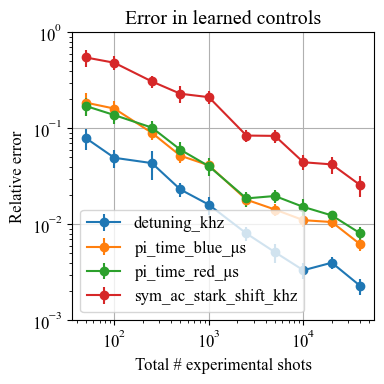

In [7]:
import PyPlot
const plt = PyPlot;
import Statistics

total_n_shots = [n_shots * length(tspan_experiment) for n_shots in n_shots_list]

plt.figure(figsize=(4,4))

for (index, label) in enumerate(fieldnames(HamiltonianParameters))
    means = []
    stderrs = []
    for n_shots in n_shots_list
        relative_errors = [abs(errors[index]) for errors in relative_error_results[n_shots]]
        push!(means, mean(relative_errors))
        push!(stderrs, Statistics.std(relative_errors) / sqrt(length(relative_errors)))
    end
    plt.errorbar(x=total_n_shots, y=means, yerr=stderrs, linestyle="-", marker="o", label=label)
end

plt.title("Error in learned controls")
plt.ylim(1e-3, 1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Total # experimental shots")
plt.ylabel("Relative error")
plt.legend()
plt.grid();
plt.tight_layout();
plt.savefig("control_learning_ms_relative_error.pdf", bbox_inches="tight")

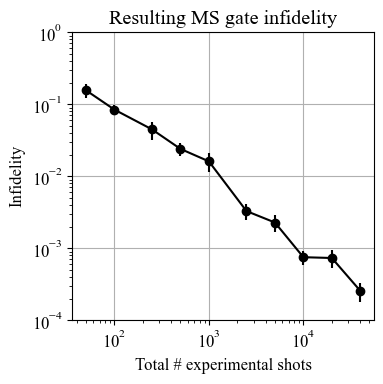

In [8]:
import PyPlot
const plt = PyPlot;
using Statistics

fidelity_means = []
fidelity_stderrs = []
for n_shots in n_shots_list
    push!(fidelity_means, mean(fidelities[n_shots]))
    push!(fidelity_stderrs, Statistics.std(fidelities[n_shots]) / sqrt(length(fidelities[n_shots])))
end

plt.figure(figsize=(4,4))
plt.errorbar(x=total_n_shots, y=1 .- fidelity_means, yerr=fidelity_stderrs, linestyle="-", marker="o", color="black")

plt.title("Resulting MS gate infidelity")
plt.ylim(1e-4, 1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Total # experimental shots")
plt.ylabel("Infidelity")
plt.grid();
plt.tight_layout();
plt.savefig("control_learning_ms_infidelity.pdf", bbox_inches="tight")

## Print the raw result data

In [9]:
print(relative_error_results)

Dict{Any,Any}(2000 => Any[[0.0023997134963996913, 0.015802431094464886, -0.026234524491574134, 0.051193126885719864], [0.006338536687321828, -0.005374135945576697, -0.007069316876384869, 0.05261875663956572], [0.0036484186445424173, -0.008897097014856747, -0.010624562087156342, 0.00787731560647309], [0.003015991707072274, 0.010264897979941168, -0.020966357992519034, -0.05540600907168147], [0.005200160916926322, -0.009245659562623132, 0.021106778922039, -0.037669124872933946], [0.0015557450938642249, 0.014345115937701537, -0.02313332770414814, 0.0011159501397728366], [-0.006899860136701718, -0.01250207991229164, 0.01333367245998345, 0.05158247705946162], [-0.006009213866592589, -0.001929135080946409, 0.010599368930115942, -0.000415290176888794], [0.0005462633418863661, -0.0019680517158150224, 0.003480420224286946, -0.029275735158165173], [0.004252814886718781, 0.01193408906366784, -0.01129176024968118, -0.02600856458496148], [0.002068841901878571, 0.010868895188877481, -0.01507697500379

, 0.08612709410062336], [-0.0008897456800717407, -0.010280026436870138, 0.00876491829628266, 0.01935531915661126], [-0.0005026954396869954, -0.0032768493743393634, 0.0007259863014975768, -0.026227266080629308], [0.0018586611328846204, 0.00017746971372911702, -0.010388932655893055, -0.009096058011472063], [-0.001557604057687101, -0.009975775852827695, 0.013098647262996874, 0.0019395588113562123], [0.0010680451425706394, -0.010718322162589722, 0.012893214913272364, -0.04705787029977948], [-0.004531283432126188, 0.008494833352634502, -0.012861971886716006, 0.027275324738366247]],500 => Any[[0.005504106811796916, 0.0065032346346384886, -0.03779037697111371, 0.12210245438303924], [-0.0036627759682492213, -0.009615249670963166, 0.020398476200319444, 0.06939105122128608], [0.000970570117009828, 0.005254755529479027, 0.012605609838090765, -0.05018522706674888], [-0.005316477501323291, -0.01574639146959047, 0.028930591035986403, 0.022230452077132368], [-0.006033939998754434, -0.0349073069022878

In [10]:
print(fidelities)

Dict{Any,Any}(2000 => Any[0.9998546915357803, 0.9995363756724825, 0.999861469121262, 0.9983951939873796, 0.9991126774145387, 0.9995731866763786, 0.9985326380174324, 0.9998427508629791, 0.9998320976218557, 0.9991932154283898, 0.9991321833074274, 0.9957977441030226, 0.9997380564784232, 0.9990544465028767, 0.9997768040482612, 0.9993574036770828, 0.9993825298434565, 0.9999114998964713, 0.9997330983421598, 0.9997088788407645],25 => Any[0.9976943185318337, 0.9736608902866355, 0.9626414074082988, 0.7995161002776983, 0.9464806740216151, 0.9867028594998782, 0.9197602501851477, 0.9958651241119312, 0.8084273788183103, 0.9797362143346483, 0.9758662604118852, 0.989126475454019, 0.9900258778918313, 0.9431193202366542, 0.9845378189825775, 0.9325759125378992, 0.9636404471968132, 0.9723374265282984, 0.9878994738736575, 0.9928133254881909],10 => Any[0.8031753062345213, 0.8906367029530664, 0.946583301521739, 0.9455329118779018, 0.9264693830783746, 0.9465403966928576, 0.932430244743135, 0.8394922971664426